# word2vec

word2vec を使って本のタイトルからそれに似た本を探します。

## reference

* gensim - word2vec: https://radimrehurek.com/gensim/models/word2vec.html

In [1]:
from gensim.models import Word2Vec
import matplotlib.pyplot as plt
import numpy as np
import os
from datetime import datetime
import pandas as pd

% matplotlib inline

### 準備

データセットを読み込んでモデルに投入できる形にしていきます

In [2]:
df_logs = pd.read_csv("../data/train/reading_logs.tsv", sep="\t")
df_books = pd.read_csv("../data/train/books.tsv", sep="\t")

df_logs.book_id = df_logs.book_id.astype("str")
df_books.id = df_books.id.astype("str")
df_books = df_books.rename(columns=dict(id="book_id"))

df_books = df_logs.groupby("book_id", as_index=False).count()\
    .rename(columns=dict(user_id="count"))[["book_id", "count"]]\
    .merge(right=df_books, on="book_id", how="right")

#### ユーザーごとの文章(読書記録) の作成

1. データセットの中にあるユニークなユーザーを取得
2. その中からサンプルとして 3000 人を選選択
3. 各ユーザの読書記録にある本のidを配列にして取得し `sentences` として保存

In [3]:
unique_user_ids = df_logs.user_id.unique()
chosen_user_ids = np.random.choice(unique_user_ids, size=3000)
sentences = [list(df_logs[df_logs.user_id == x].book_id.values) for x in chosen_user_ids]

## Train Word2Vec Model !

データの読み込みが終わったので次にモデルを訓練していきます。  
Word2Vec はインスタンス生成と同時に学習を開始します。

第一引数には 各文章の単語の入った配列 の配列を渡します。(必須)

#### 学習に関係するパラメータ

主要なパラメータについて簡単に記述していきます[^1]

* workers: 使うスレッドの数.
* iter: トレーニングデータ全体を何回学習させるか. 一般には `epochs` と呼ばれることの方が多い

その他はモデルのハイパパラメータです。

* size: 隠れ層の次元数. 4 の倍数にすることが推奨(実装の関係上早いよう)
* window: 考慮する n-gram の幅.
* sg: 1 の時 skip-gram の形式を用いる. 0 の時には continuous-Bag-Of-Words の形式を用いる.  
  skip-gram は中心の単語から周辺の単語を予測するのに対し、 c-bow の場合は反対に周辺単語から中心を予測する。
* hs: 1 の時 Hierachical Softmax を用いて近似を行う。0の時には Negative Sampling で近似を行う.
* negative: hs=0 の時に使う Negative Sample の数. 大きければ大きいほど正確に近似できるが計算コストも高い.

[^1]: 詳細は https://radimrehurek.com/gensim/models/word2vec.html を参考に

In [4]:
model = Word2Vec(sentences,
                 workers=6,
                 iter=20,
                 alpha=0.05,
                 size=32, 
                 window=10, 
                 sg=0, 
                 hs=0, 
                 negative=20)

### モデルを保存する

学習が終わったら、学習済みのモデルを保存していつでも呼び出せるようにしておきます。

大規模な実験や、試行錯誤を繰り返すような場合は、あとで学習時に使ったパラメータを辿れるようにしておけるように予め設計しておくことが大切です。  
ちゃんと設計をしていないと、再現実験を行えず大変苦労します。本当に。

In [5]:
def save_model(model, output_dir="../checkpoints"):
    if os.path.exists(output_dir) is False:
        os.makedirs(output_dir)
    now = datetime.now()
    now = now.strftime("%Y-%m-%d_%H-%m")
    fpath = os.path.join(output_dir, "w2v_{}.model".format(now))
    model.save(fpath)

In [6]:
save_model(model)

In [7]:
def book_id_to_record(book_id):
    """
    本のid からその本に紐づくレコードを返します. レコードにはタイトル及び本のidが含まれます
    """
    matches = df_books[df_books.book_id == str(book_id)]
    if len(matches) < 1:
        return None
    
    return matches.head(1)

### 似ている単語を検索する

`Word2Vec` インスタンスには wv プロパティがありそのメソッドとして単語から類似の単語を検索できる `most_similar` が用意されています。

most_similar はもっとも類似している上位 n 件の単語を返すメソッドです

* positive:   
    与えられた単語のベクトルを検索ベクトルにプラスします。よってこれに**似ている**単語を返すようになります
* negative:  
    与えられた単語のベクトルを検索ベクトルにマイナスします。よってこれに**似ていない**単語が帰るようになります。

In [8]:
for k in list(model.wv.vocab.keys())[-10:]:
    print("query: " + book_id_to_record(k).title.values[0])
    sim = model.wv.most_similar(positive=k)
    
    print("most similar: ", book_id_to_record(sim[0][0]).title.values[0], sim[0][1])

query: ぼうしころころ (つみきのえほん 1)
most similar:  ラーメンちゃん 0.848590612411499
query: ぶーらんぶーらんたのしいね (乳幼児かみしば…
most similar:  ぽんぽん山の月 (えほんのもり 7) 0.8650720119476318
query: かんたん が おいしい!: スーパー主婦・足…
most similar:  ローマ亡き後の地中海世界4: 海賊、そして海… 0.6916893720626831
query: 絵本美術館のある旅 (MOE BOOKS)
most similar:  ナナコロビン 2 (マーガレットコミックス … 0.8906799554824829
query: 神々の夢は迷宮 (講談社X文庫ホワイトハート)
most similar:  GATE7 1 (ジャンプコミックス) 0.7628191709518433
query: 超訳百人一首 うた恋い。【異聞】うた変。2
most similar:  今日から(マ)のつく自由業! 2 (あすかコ… 0.7505992650985718
query: 恋読  本に恋した2年9ヶ月
most similar:  ピロウボーイとうずくまる女のいる風景 0.7715290784835815
query: 40歳からのシンプルな暮らし 「これから」を…
most similar:  貯められない女のためのこんどこそ!貯める技術 0.7607658505439758
query: 人づき合いの断捨離セラピー
most similar:  すりへらない心をつくるシンプルな習慣 (朝日… 0.7750526070594788
query: よろず暗やみ解決屋 戦国敗者の復活ゲーム (…
most similar:  女王の花 5 (フラワーコミックス) 0.8347162008285522


In [9]:
def fuzzy_title_search(query):
    return df_books[df_books.title.str.contains(query, na=False)].sort_values("count", ascending=False).head()

In [10]:
def get_similar_books(title, top_n=10):
    _df = df_books[df_books.title == str(title)]
    if len(_df) == 0:
        print("not mach exactly. use fuzzy search")
        _df = fuzzy_title_search(title)
        if len(_df) == 0:
            print("{} not in book master data".format(title))
            return None
    
    book_id = _df.book_id.values[0]
    book_id = str(book_id)
    print(book_id)
    
    # check book id exist in model's vocabrary
    if book_id not in model.wv.vocab.keys():
        print("{} is not in model vocabrary".format(title))
        return None
    
    sim = model.wv.most_similar(positive=book_id, topn=top_n)
    return sim, _df.head(1).to_dict(orient="row")[0]

In [11]:
fuzzy_title_search("もやしもん")

book_id  count                title  \
317545   580544     86   もやしもん(1) (イブニングKC)   
317547   580547     67   もやしもん(2) (イブニングKC)   
114331  2426282     64  もやしもん(10) (イブニングKC)   
309307   572244     63   もやしもん(8) (イブニングKC)   
317568   580565     61   もやしもん(7) (イブニングKC)   

                                    author_id  
317545  %E7%9F%B3%E5%B7%9D+%E9%9B%85%E4%B9%8B  
317547  %E7%9F%B3%E5%B7%9D+%E9%9B%85%E4%B9%8B  
114331  %E7%9F%B3%E5%B7%9D+%E9%9B%85%E4%B9%8B  
309307  %E7%9F%B3%E5%B7%9D+%E9%9B%85%E4%B9%8B  
317568  %E7%9F%B3%E5%B7%9D+%E9%9B%85%E4%B9%8B

In [12]:
def plot_similar_books(query):
    sims, query_record = get_similar_books(query)

    df_sims = pd.DataFrame(sims, columns=["book_id", "similarity"])
    df_sims = pd.merge(df_sims, df_books, on="book_id", how="left")

    ax = df_sims.set_index("title")["similarity"].iloc[::-1].plot(kind="barh", color="C0")
    ax.set_title("検索ワード: {}".format(query_record["title"]))
    return ax

579419


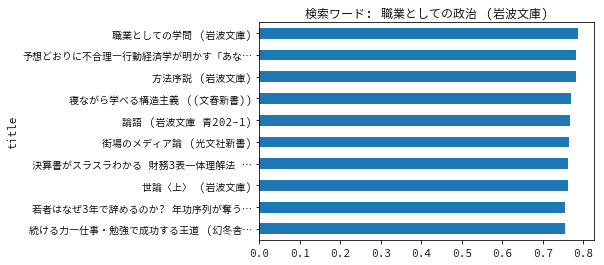

In [13]:
plot_similar_books("職業としての政治 (岩波文庫)")

not mach exactly. use fuzzy search
288696


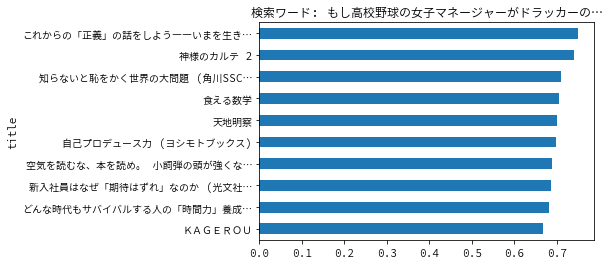

In [14]:
plot_similar_books("野球")

573840


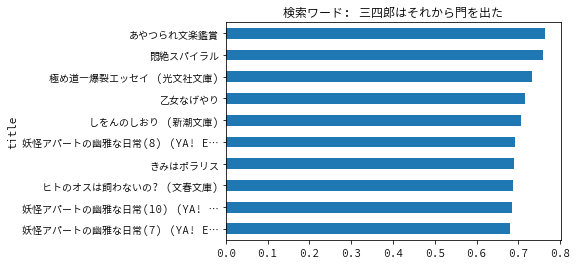

In [15]:
plot_similar_books("三四郎はそれから門を出た")

556977


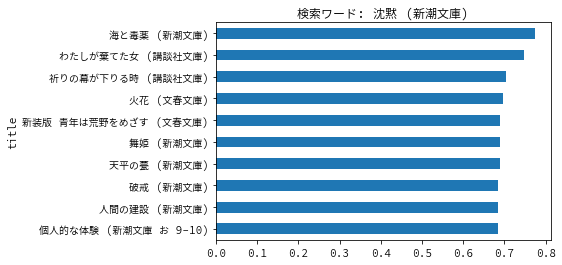

In [16]:
plot_similar_books("沈黙 (新潮文庫)")

not mach exactly. use fuzzy search
580544


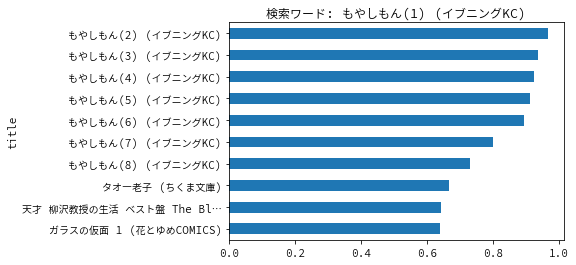

In [17]:
plot_similar_books("もやしもん")